# 3.5.2. Ejemplo Práctico: Movie Ratings

## Carga de Módulos

In [3]:
%pip install yellowbrick


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
# import session_info
from time import time
from plotly.subplots import make_subplots
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

# Tema Principal
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import sys

# sys.path.append('../scripts')
from funny_stuffs import score_plot, calculate_elbow_point, plot_elbow_method

## Configuración Inicial

In [3]:
random_seed = 333  # Semilla para reproducibilidad de resultados
np.random.seed(random_seed)  # Para reproducibilidad

# Configuración de opciones de visualización para pandas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', 15)  # Ajusta el número de filas a mostrar
pd.set_option('display.max_colwidth', None) # Ajusta del tamaño de descr

# Configuraciones extras
sns.set_style('dark')
dark_template = pio.templates['plotly_dark'].to_plotly_json()
dark_template['layout']['paper_bgcolor'] = 'rgba(30, 30, 30, 0.5)'
dark_template['layout']['plot_bgcolor'] = 'rgba(30, 30, 30, 0.5)'
pio.templates['plotly_dark_semi_transparent'] = go.layout.Template(dark_template)
pio.templates.default = 'plotly_dark_semi_transparent'
set_config(transform_output="pandas")
set_config(display='diagram')
warnings.filterwarnings("ignore")
%matplotlib inline

# Configuración para intentar aplicar un estilo oscuro
plt.rcParams['figure.facecolor'] = 'black'  # Color de fondo de la figura
plt.rcParams['axes.facecolor'] = 'black'  # Color de fondo de los ejes
plt.rcParams['axes.edgecolor'] = 'white'  # Color de los bordes de los ejes
plt.rcParams['axes.labelcolor'] = 'white'  # Color de las etiquetas de los ejes
plt.rcParams['xtick.color'] = 'white'  # Color de las marcas de x
plt.rcParams['ytick.color'] = 'white'  # Color de las marcas de y
plt.rcParams['text.color'] = 'white'  # Color del texto

## Ejemplo Práctico

#### Preparación de los Datos

**Objetivo**

Desarrollar un sistema de recomendación de películas personalizado, utilizando el conjunto de datos de MovieLens, para mejorar la experiencia de los usuarios al ofrecerles sugerencias de películas basadas en sus gustos y preferencias individuales.

**Planteamiento del Problema**

Ante la creciente cantidad de opciones cinematográficas disponibles, los usuarios de plataformas de streaming y servicios de entretenimiento enfrentan el desafío de seleccionar películas que se alineen con sus intereses y preferencias. Utilizando el conjunto de datos de MovieLens, que contiene calificaciones de usuarios, información demográfica y detalles de películas, se busca implementar un sistema de recomendación eficaz. Este sistema analizará las interacciones previas de los usuarios con el catálogo de películas para identificar patrones y preferencias, con el fin de sugerir nuevas películas que probablemente sean de su interés.

**Conjunto de Datos**

Los datos utilizados para este proyecto han sido recolectados por el GroupLens Research Project en la Universidad de Minnesota. El conjunto de datos incluye 100,000 calificaciones de 0 a 5 otorgadas por 943 usuarios a 1682 películas, junto con información demográfica básica de los usuarios. Todos los usuarios han calificado al menos 20 películas, asegurando un mínimo de interacción para informar las recomendaciones.

In [4]:
# Carga y diccionario del conjunto de datos
ratings, movies = pd.read_pickle('../data/movie_ratings.pkl')

Análizamos un poco sobre el contexto de nuestro conjunto de datos:

In [5]:
ratings.sample(5)

,user_id,movie_id,rating
44617,234,416,4
66290,358,45,3
98451,515,332,3
60487,445,79,4
71499,637,740,2


In [6]:
ratings.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [7]:
movies

,movie_id,movie_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [8]:
# Peliculas con el mejor rating
top_sample_movies = ratings[ratings.rating == ratings.rating.max()].sample(10).movie_id
movies[movies.movie_id.isin(top_sample_movies)]

,movie_id,movie_name
0,1,Toy Story (1995)
153,154,Monty Python's Life of Brian (1979)
167,168,Monty Python and the Holy Grail (1974)
178,179,"Clockwork Orange, A (1971)"
183,184,Army of Darkness (1993)
248,249,Austin Powers: International Man of Mystery (1997)
264,265,"Hunt for Red October, The (1990)"
302,303,Ulee's Gold (1997)
497,498,"African Queen, The (1951)"
738,739,Pretty Woman (1990)


In [9]:
# Peliculas con el peor rating
top_sample_movies = ratings[ratings.rating == ratings.rating.min()].sample(10).movie_id
movies[movies.movie_id.isin(top_sample_movies)]

,movie_id,movie_name
197,198,Nikita (La Femme Nikita) (1990)
276,277,Restoration (1995)
342,343,Alien: Resurrection (1997)
550,551,Lord of Illusions (1995)
742,743,"Crow: City of Angels, The (1996)"
785,786,"Perez Family, The (1995)"
889,890,Mortal Kombat: Annihilation (1997)
1000,1001,"Stupids, The (1996)"
1271,1272,Talking About Sex (1994)
1651,1652,Temptress Moon (Feng Yue) (1996)


Para realizar la modelación requerimos transformar nuestros datos:

In [10]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [11]:
# Rellenamos los faltantes con cero, asumiendo que estas películas no han sido vistas:
users = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
users.head()

movie_id  1     2     3     4     5     6     7     8     9     10    11    \
user_id                                                                      
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0   2.0   
2          4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   4.0   
5          4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

movie_id  12    13    14    15    16    17    18    19    20    21    22    \
user_id                                                                      
1          5.0   5.0   5.0   5.0   5.0   3.0   4.0   5.0   4.0   1.0   4.0   
2          0.0   4.0   4.0   0.0   0.0   0.0   0.0   3.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   3.0   0.0   

movie_id  23    24    25    26    27    28    29    30    31    32    33    \
user_id                                                                      
1          4.0   3.0   4.0   3.0   2.0   4.0   1.0   3.0   3.0   5.0   4.0   
2          0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   4.0   3.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   

movie_id  34    35    36    37    38    39    40    41    42    43    44    \
user_id                                                                      
1          2.0   1.0   2.0   2.0   3.0   4.0   3.0   2.0   5.0   4.0   5.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   5.0   0.0   0.0   

movie_id  45    46    47    48    49    50    51    52    53    54    55    \
user_id                                                                      
1          5.0   4.0   4.0   5.0   3.0   5.0   4.0   4.0   3.0   3.0   5.0   
2          0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   

movie_id  56    57    58    59    60    61    62    63    64    65    66    \
user_id                                                                      
1          4.0   5.0   4.0   5.0   5.0   4.0   3.0   2.0   5.0   4.0   4.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   0.0   0.0   0.0   0.0   4.0   1.0   0.0   0.0   1.0   

movie_id  67    68    69    70    71    72    73    74    75    76    77    \
user_id                                                                      
1          3.0   4.0   3.0   3.0   3.0   4.0   3.0   1.0   4.0   4.0   4.0   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5          0.0   0.0   1.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

movie_id  78    79    80    81    82    83    84    85    86    87    88    \
user_id                                                                      
1          1.0 

In [12]:
# Ordenamos los usuarios por número de columnas distintas de cero
users = users.reindex(users.astype(bool).sum(axis=1).sort_values(ascending=False).index)

# select top 120 users
users = users[:120]

Nuestros usuarios top, han visto:

In [13]:
str((users.astype(bool).sum(axis=1).mean() / users.shape[1] * 100).round(2)) + ' %'

'18.83 %'

del catálogo total. Ahora removeremos las películas que no han sido vistas por al menos 60 (50%) de nuestro top:

In [14]:
users = users.loc[:, users.astype(bool).sum(axis=0) >= 60]

Para hacer el recomendador y entender a profundidad como se ve, realizaremos el corte 90:10:

In [15]:
# train test split 9:1
train = users.iloc[:int(users.shape[0] * 0.9), :]
print('train.shape:', train.shape)
test = users.iloc[int(users.shape[0] * 0.9):, :]
print('test.shape:', test.shape)
print('users.shape:', users.shape)

train.shape: (108, 178)
test.shape: (12, 178)
users.shape: (120, 178)


#### Implementación y Evaluación de los métodos

In [16]:
distortions = []; silhouette_scores = []
davies_bouldin_scores = []; calinski_harabasz_scores = []
range_n_clusters = range(2, 8)  # Ajustamos para explorar desde 1 hasta 7 clusters

for n_clusters in range_n_clusters:
   km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=random_seed)
   cluster_labels = km.fit_predict(train); distortions.append(km.inertia_)
   silhouette_ = silhouette_score(train, cluster_labels); silhouette_scores.append(silhouette_)
   davies_bouldin_ = davies_bouldin_score(train, cluster_labels); davies_bouldin_scores.append(davies_bouldin_)
   calinski_harabasz_ = calinski_harabasz_score(train, cluster_labels); calinski_harabasz_scores.append(calinski_harabasz_)

In [17]:
optimal_k = calculate_elbow_point(distortions)
plot_elbow_method(range_n_clusters, distortions, optimal_k)

In [18]:
score_plot(scores=silhouette_scores, range_n_clusters=range_n_clusters, 
         operator='max', name_index = 'Índice de Silueta')

In [19]:
score_plot(scores=calinski_harabasz_scores, range_n_clusters=range_n_clusters, 
         operator='max', name_index = 'Índice de C-H')

In [20]:
score_plot(scores=davies_bouldin_scores, range_n_clusters=range_n_clusters, 
         operator='min', name_index = 'Índice de D-B')

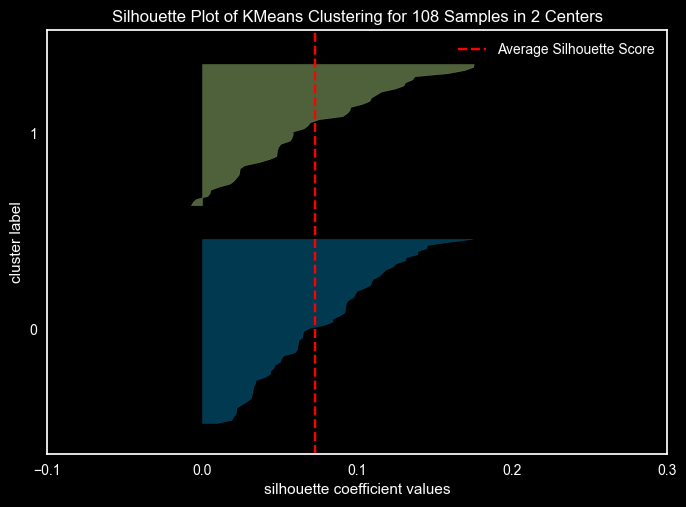

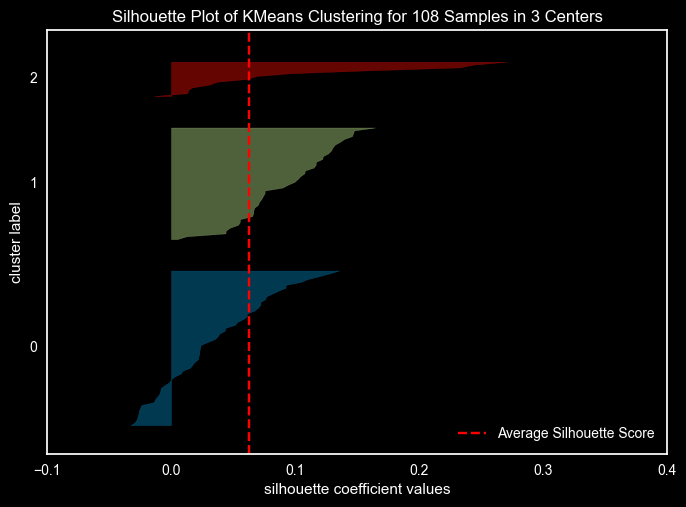

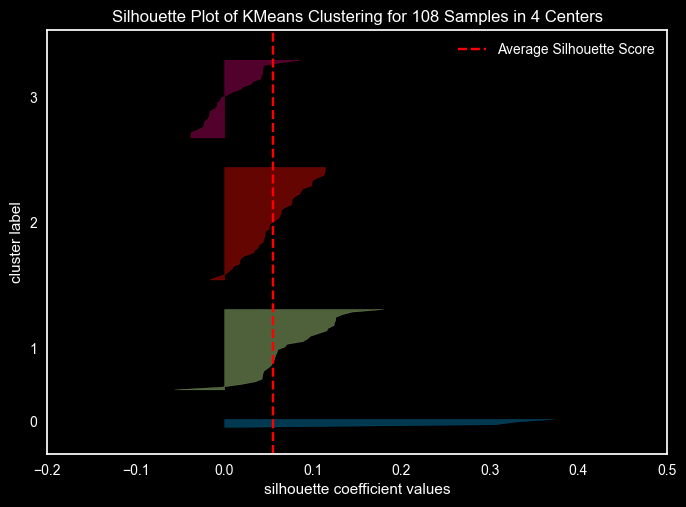

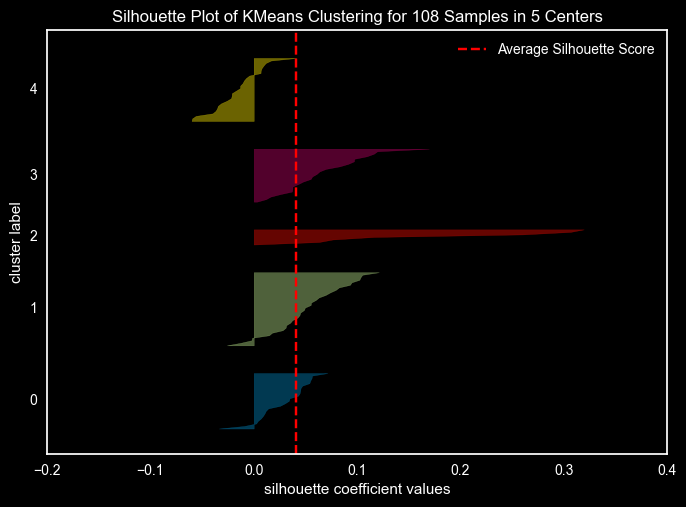

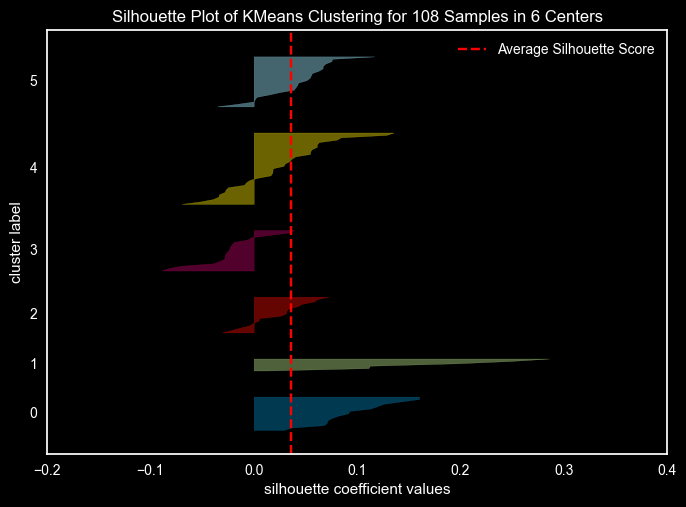

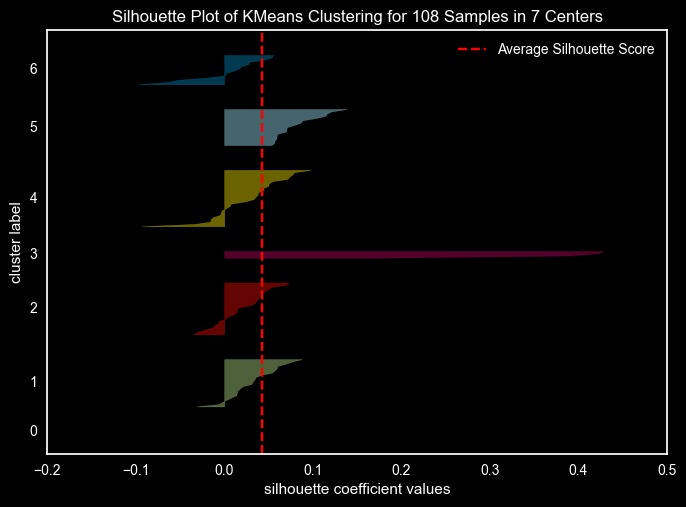

In [21]:
for i in range(2, 8):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=random_seed)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(train)
    visualizer.show()


In [22]:
# Generamos KMeans con 2 Clusters
km = KMeans(n_clusters=2, init='k-means++',
            n_init=10, max_iter=300, random_state=random_seed)
km.fit(train)

KMeans(n_clusters=2, n_init=10, random_state=333)

In [23]:
movies.iloc[train[km.labels_ == 0].mean(axis=0).sort_values(ascending=False).head(3).index]['movie_name'].to_list()

['Legends of the Fall (1994)', 'Brazil (1985)', 'Princess Bride, The (1987)']

In [24]:
movies.iloc[train[km.labels_ == 1].mean(axis=0).sort_values(ascending=False).head(3).index]['movie_name'].to_list()

['Heavy Metal (1981)',
 'Everyone Says I Love You (1996)',
 'Nikita (La Femme Nikita) (1990)']

In [25]:
# Generamos el recomendador
def get_recommendations(user):
    print(f"Recomendaciones para el usuario {user.name}:")
    # Encontrar el cluster al que pertenece el usuario
    cluster_id = km.predict(user.to_numpy().reshape(1, -1))
    cluster = train[km.labels_ == cluster_id]

    # Encontrar columnas con valores cero en la fila user_id
    unrated_movies = train.columns[user == 0]

    # Encontrar las películas mejor valoradas en el cluster que user_id no ha valorado
    recommendations = cluster[unrated_movies].mean().sort_values(ascending=False).head(10)
    recommendations = movies.iloc[recommendations.index]['movie_name'].to_list()
    return recommendations

In [26]:
recommendations = get_recommendations(test.iloc[0])
print(*recommendations, sep = "\n")

Recomendaciones para el usuario 345:
2001: A Space Odyssey (1968)
Supercop (1992)
Maltese Falcon, The (1941)
Blues Brothers, The (1980)
Mr. Smith Goes to Washington (1939)
Spawn (1997)
Unbearable Lightness of Being, The (1988)
Wrong Trousers, The (1993)
It Happened One Night (1934)
Children of the Corn: The Gathering (1996)


**Conclusión**

Aplicar el método de $k$-means para recomendaciones de películas resulta en un enfoque efectivo que personaliza la experiencia del usuario al analizar y comparar sus gustos con los de otros espectadores similares. Este sistema actúa como un filtro inteligente, seleccionando de entre un amplio catálogo aquellas opciones más alineadas con nuestras preferencias previas. De esta manera, $k$-means facilita el descubrimiento de nuevas películas, enriqueciendo nuestra experiencia de entretenimiento con sugerencias precisas y pertinentes.